# Chest X‑Ray Pneumonia Classification



EDA → Baseline CNN → Transfer‑Learning MobileNetV2



> **Dataset:** [Chest X‑Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) – ≈5 800 JPEGs split into train/val/test and classes **NORMAL / PNEUMONIA**.

>

> **Goal:** build a baseline CNN ≤1 M params and an improved model (transfer‑learning) that beats it by ≥ 5 % ROC‑AUC.

>

> **Author:** *Katrin Pochtar* – June 2025.

## 0  Setup & Imports

In [1]:

import os, json, random, zipfile, warnings, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve,
                             confusion_matrix, precision_score, recall_score, f1_score)

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
warnings.filterwarnings("ignore")


from tensorflow.keras import backend as K


SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_59819/867542849.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


We keep the full dataset by default.

In [2]:
DATA_DIR = Path("data")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"
TEST_DIR  = DATA_DIR / "test"


## 1  Exploratory Data Analysis (EDA)

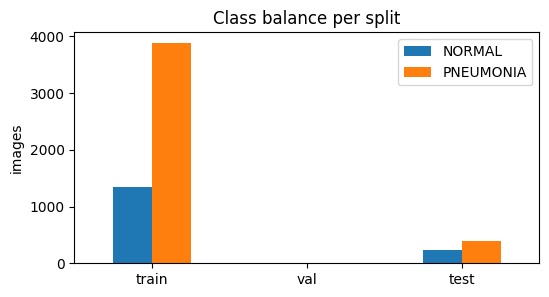

In [3]:
def class_distribution(split_dir: Path):
    counts = {cls: len(list((split_dir / cls).iterdir())) for cls in ["NORMAL", "PNEUMONIA"]}
    return pd.Series(counts, name=split_dir.name)

distrib = pd.concat([
    class_distribution(TRAIN_DIR),
    class_distribution(VAL_DIR),
    class_distribution(TEST_DIR)
], axis=1)

distrib.T.plot(kind="bar", figsize=(6,3), rot=0, title="Class balance per split");
plt.ylabel("images"); plt.show()


**Observation.** Severe imbalance: *PNEUMONIA* ≈ 3× *NORMAL* in train; we therefore report ROC‑AUC & F1 in addition to Accuracy and will monitor Recall closely.



### Atypical / Low‑quality examples

We flag blurry images via the variance‑of‑Laplacian heuristic (< 50) and visualise a few.

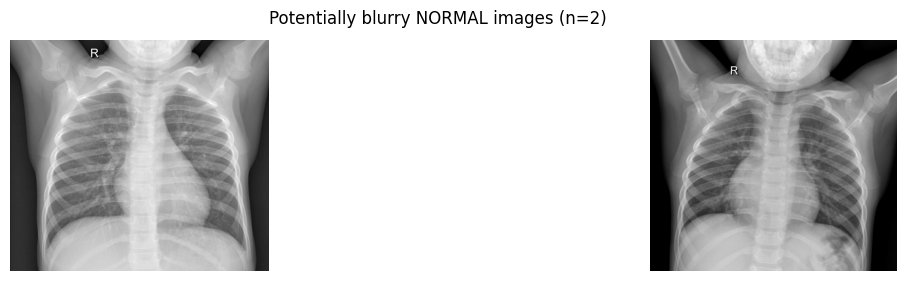

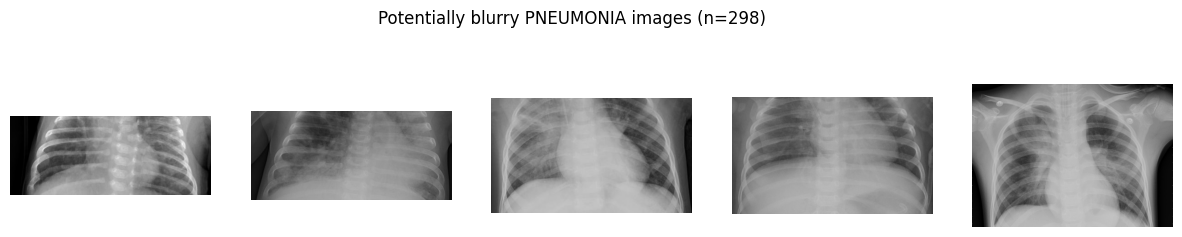

In [4]:
def variance_of_laplacian(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

def plot_blurry(split_dir, cls, n=5, thresh=50):
    imgs = list((split_dir/cls).iterdir())
    blurry = [p for p in imgs if variance_of_laplacian(cv2.imread(str(p), 0)) < thresh]
    sel = random.sample(blurry, min(n, len(blurry)))
    if not sel: return
    plt.figure(figsize=(15,3));
    for i,p in enumerate(sel,1):
        plt.subplot(1,len(sel), i); plt.imshow(Image.open(p), cmap="gray"); plt.axis("off")
    plt.suptitle(f"Potentially blurry {cls} images (n={len(blurry)})")
    plt.show()

plot_blurry(TRAIN_DIR, "NORMAL"); plot_blurry(TRAIN_DIR, "PNEUMONIA")


**Decision:** We keep all images (to preserve sample size) and rely on augmentation + model robustness.

## 2  Data Pipeline

Because the official val/ folder holds only 16 images, we instead carve out a validation set from the training data using validation_split = 0.15. This gives the model a more representative sample for early stopping and hyper‑parameter tuning.

* 224 × 224 resize  

* Pixel scale to [‑1, 1] (rescale=1/127.5‑1)  

* Augmentations (≥ 3): rotation ±10°, width/height shift 10 %, horizontal flip off (lungs are not bilaterally symmetric for pathology), zoom 10 %, brightness 0.8–1.2

In [5]:
MAX_IMAGES = int(os.getenv("MAX_IMAGES", "0"))  # 0 = use all

# normalise images to [-1, 1] range
def to_minus1_plus1(x):
    """Convert uint8 [0‥255] → float32 [-1‥1]."""
    return x / 127.5 - 1.0

# data generators
a_train = ImageDataGenerator(
    preprocessing_function=to_minus1_plus1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    validation_split=0.15,
    horizontal_flip=False,   # flips are unsafe for chest X-rays
    fill_mode="nearest"
)

a_test = ImageDataGenerator(
    preprocessing_function=to_minus1_plus1
)

common_args = dict(target_size=(224, 224),
                   batch_size=32,
                   class_mode="binary")

def flow_limited(datagen, directory, subset=None):
    gen = datagen.flow_from_directory(
        directory,
        subset=subset,
        shuffle=(subset == "training"),
        **common_args
    )
    return gen

train_gen = flow_limited(a_train, TRAIN_DIR, subset="training")
val_gen   = flow_limited(a_train, TRAIN_DIR, subset="validation")
test_gen  = a_test.flow_from_directory(TEST_DIR,
                                       shuffle=False,
                                       **common_args)


Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 3  Utility – Metric Printer & Plots

In [6]:
from collections import OrderedDict

def print_metrics(name, y_true, y_prob):
    y_pred = (y_prob > 0.5).astype(int)
    metrics = OrderedDict([
        ("Accuracy",      np.mean(y_pred==y_true)),
        ("Precision",     precision_score(y_true, y_pred)),
        ("Recall",        recall_score(y_true, y_pred)),
        ("F1",            f1_score(y_true, y_pred)),
        ("ROC_AUC",       roc_auc_score(y_true, y_prob))
    ])
    print(f"\n{name}")
    for k,v in metrics.items():
        print(f"{k:>9}: {v:.3f}")
    return metrics

def roc_plot(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=label)


## 4  Baseline – Simple CNN (≤ 1 M parameters)

In [7]:
baseline = Sequential([
    Conv2D(32, 3, activation="relu", input_shape=(224,224,3)),
    MaxPooling2D(2),

    Conv2D(64, 3, activation="relu"),
    MaxPooling2D(2),

    Conv2D(128, 3, activation="relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(1, activation="sigmoid")
])

baseline.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

baseline.summary()

hist_base = baseline.fit(train_gen, epochs=15, validation_data=val_gen)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 90s 641ms/step - accuracy: 0.7408 - loss: 0.6095 - val_accuracy: 0.7430 - val_loss: 0.5680
Epoch 2/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 97s 700ms/step - accuracy: 0.7386 - loss: 0.5409 - val_accuracy: 0.7276 - val_loss: 0.4883
Epoch 3/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 100s 716ms/step - accuracy: 0.8141 - loss: 0.3795 - val_accuracy: 0.8542 - val_loss: 0.2838
Epoch 4/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 100s 715ms/step - accuracy: 0.8506 - loss: 0.3373 - val_accuracy: 0.8517 - val_loss: 0.3019
Epoch 5/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 100s 719ms/step - accuracy: 0.8669 - loss: 0.2973 - val_accuracy: 0.8581 - val_loss: 0.2827
Epoch 6/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 100s 718ms/step - accuracy: 0.8767 - loss: 0.2979 - val_accuracy: 0.8734 - val_loss: 0.2610
Epoch 7/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 101s 723ms/step - accuracy: 0.8828 - loss: 0.2706 - val_accuracy: 0.8862 - val_loss: 0.2478
Epoch 8/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 101s 722ms/step - accuracy: 0.8890 - l

### Learning curves – baseline

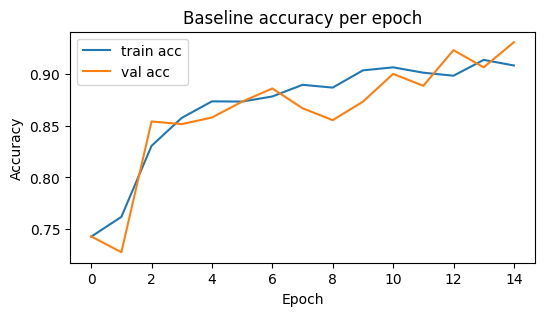

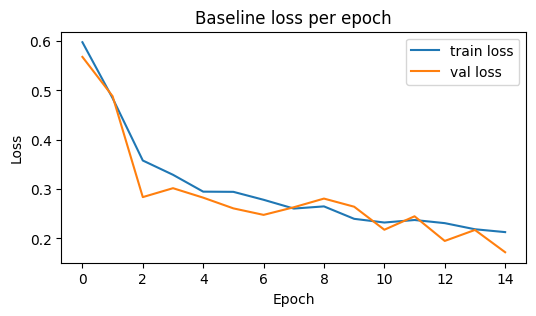

In [8]:
plt.figure(figsize=(6,3))
plt.plot(hist_base.history['accuracy'], label='train acc')
plt.plot(hist_base.history['val_accuracy'], label='val acc')
plt.title('Baseline accuracy per epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(hist_base.history['loss'], label='train loss')
plt.plot(hist_base.history['val_loss'], label='val loss')
plt.title('Baseline loss per epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

### Baseline metrics


Baseline
 Accuracy: 0.540
Precision: 0.879
   Recall: 0.931
       F1: 0.904
  ROC_AUC: 0.941


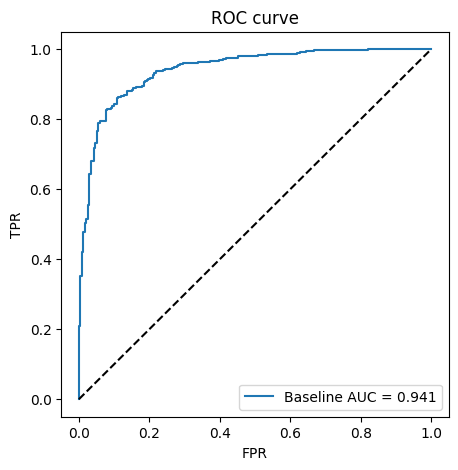

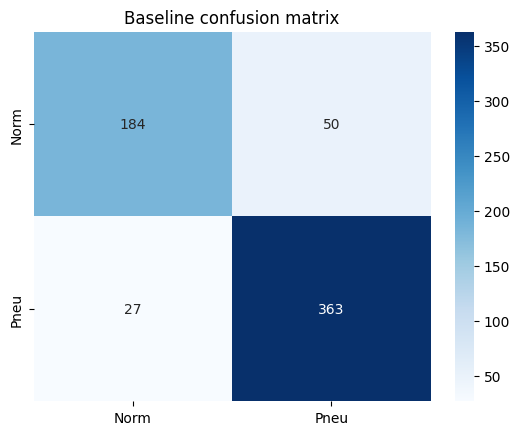

In [9]:
y_true_test = test_gen.classes
probs_base  = baseline.predict(test_gen, verbose=0)
metrics_base = print_metrics("Baseline", y_true_test, probs_base)

# ROC curve
plt.figure(figsize=(5,5))
roc_plot(y_true_test, probs_base, f"Baseline AUC = {metrics_base['ROC_AUC']:.3f}")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curve"); plt.legend(); plt.show()

# Confusion matrix
conf_base = confusion_matrix(y_true_test, (probs_base>0.5).astype(int))
sns.heatmap(conf_base, annot=True, fmt='d', cmap='Blues', xticklabels=['Norm','Pneu'], yticklabels=['Norm','Pneu'])
plt.title("Baseline confusion matrix"); plt.show()

## 5  Improved Model – Transfer Learning (MobileNetV2)

We warm‑up with frozen backbone (5 epochs) then fine‑tune the last 50 layers.

In [10]:
base = MobileNetV2(input_shape=(224,224,3), include_top=False, weights="imagenet")
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.30, seed=SEED)(x)
output = Dense(1, activation="sigmoid")(x)

tl_model = Model(inputs=base.input, outputs=output)

tl_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="binary_crossentropy",
                 metrics=["accuracy", tf.keras.metrics.AUC(name="roc_auc")])

warm_hist = tl_model.fit(train_gen, epochs=5, validation_data=val_gen,
                         callbacks=[EarlyStopping(patience=2, restore_best_weights=True)])

# unfreeze last 50 layers
for layer in base.layers[-50:]:
    layer.trainable = True

tl_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="binary_crossentropy",
                 metrics=["accuracy", tf.keras.metrics.AUC(name="roc_auc")])

finetune_hist = tl_model.fit(train_gen, initial_epoch=5, epochs=13, validation_data=val_gen,
                             callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])


Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 74s 523ms/step - accuracy: 0.7987 - loss: 0.4440 - roc_auc: 0.8091 - val_accuracy: 0.9322 - val_loss: 0.1935 - val_roc_auc: 0.9789
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 71s 512ms/step - accuracy: 0.9415 - loss: 0.1646 - roc_auc: 0.9821 - val_accuracy: 0.9399 - val_loss: 0.1559 - val_roc_auc: 0.9845
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 72s 514ms/step - accuracy: 0.9445 - loss: 0.1511 - roc_auc: 0.9829 - val_accuracy: 0.9488 - val_loss: 0.1354 - val_roc_auc: 0.9874
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 72s 519ms/step - accuracy: 0.9530 - loss: 0.1216 - roc_auc: 0.9898 - val_accuracy: 0.9501 - val_loss: 0.1218 - val_roc_auc: 0.9913
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 73s 521ms/step - accuracy: 0.9500 - loss: 0.1293 - roc_auc: 0.9865 - val_accuracy: 0.9527 - val_loss: 0.1248 - val_roc_auc: 0.9901
Epoch 6/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 90s 616ms/step - accuracy: 0.9314 - loss: 0.1742 - roc_auc: 0.9745 - val_accuracy: 0.7775 - val_loss: 1.0415 -

### Transfer‑learning metrics


Transfer MobileNetV2
 Accuracy: 0.569
Precision: 0.805
   Recall: 0.997
       F1: 0.891
  ROC_AUC: 0.978


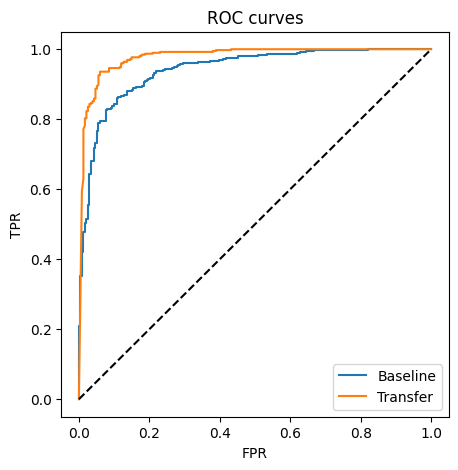


ROC-AUC improvement: 0.03687815033968889


In [11]:
probs_tl  = tl_model.predict(test_gen, verbose=0)
metrics_tl = print_metrics("Transfer MobileNetV2", y_true_test, probs_tl)

plt.figure(figsize=(5,5))
roc_plot(y_true_test, probs_base, "Baseline")
roc_plot(y_true_test, probs_tl,   "Transfer")
plt.plot([0,1],[0,1],'k--'); plt.legend(); plt.title("ROC curves"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

improvement = metrics_tl['ROC_AUC'] - metrics_base['ROC_AUC']
print(f"\nROC-AUC improvement: {improvement}")

## 6  Weights & Biases Sweeps

In [13]:
SWEEP_CONFIG = {
    "method": "bayes",
    "metric": {"name": "val_roc_auc", "goal": "maximize"},
    "parameters": {
        #core
        "lr":          {"distribution": "log_uniform_values", "min": 1e-6, "max": 5e-4},
        "optimizer":   {"values": ["adam", "adamw", "rmsprop"]},
        "weight_decay":{"values": [0.0, 1e-5, 1e-4, 5e-4]},
        "batch_size":  {"values": [16, 32, 64]},

        #transfer specifics
        "unfreeze":    {"values": [10, 25, 50, 75, 100]},
        "warmup_epochs":{"values": [2, 5, 8]},

        #regularisation
        "drop":        {"values": [0.1, 0.2, 0.3, 0.4]},
        "label_smooth":{"values": [0.0, 0.05, 0.1]},

        #augmentation
        "rot":         {"values": [5, 10, 15]},
        "bright":      {"values": [1.1, 1.2, 1.3]},
        "noise_std":   {"values": [0.0, 0.025, 0.05]},

        #scheduler / callbacks
        "lr_schedule": {"values": ["plateau", "cosine"]},
        "patience":    {"values": [2, 3, 5]},
    }
}

In [14]:
sweep_id = wandb.sweep(SWEEP_CONFIG, project="chest_xray")

Create sweep with ID: ybxk8lqf
Sweep URL: https://wandb.ai/katrinpochtar/chest_xray/sweeps/ybxk8lqf


In [15]:
# constants
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES  = 1  # binary

def sweep_train(config=None):
    """Train-loop used by W&B sweeps - fully parameterised."""
    with wandb.init(config=config):
        cfg = wandb.config

        # 1. DATA ----------------------------------------------------
        def build_preprocess(noise_std: float):
            def _proc(x):
                x = x / 127.5 - 1.0
                if noise_std > 0:
                    n = tf.random.normal(tf.shape(x), stddev=noise_std)
                    x = tf.clip_by_value(x + n, -1.0, 1.0)
                return x
            return _proc

        gen_args = dict(
            preprocessing_function=build_preprocess(cfg.noise_std),
            rotation_range=cfg.rot,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            brightness_range=[0.8, cfg.bright],
            validation_split=0.15,
            fill_mode="nearest",
        )
        train_datagen = ImageDataGenerator(**gen_args)
        val_datagen   = train_datagen

        flow_args = dict(
            target_size=INPUT_SHAPE[:2],
            batch_size=cfg.batch_size,
            class_mode="binary",
            seed=SEED,
        )
        train_flow = train_datagen.flow_from_directory(
            TRAIN_DIR, subset="training", shuffle=True, **flow_args
        )
        val_flow = val_datagen.flow_from_directory(
            TRAIN_DIR, subset="validation", shuffle=False, **flow_args
        )

        test_gen = None
        if os.path.isdir(TEST_DIR):
            test_datagen = ImageDataGenerator(
                preprocessing_function=build_preprocess(cfg.noise_std)
            )
            test_gen = test_datagen.flow_from_directory(
                TEST_DIR, shuffle=False, **flow_args
            )

        # 2. MODEL ---------------------------------------------------
        base = MobileNetV2(
            input_shape=INPUT_SHAPE,
            include_top=False,
            weights="imagenet",
        )
        base.trainable = False  # warm-up freeze

        x = GlobalAveragePooling2D()(base.output)
        x = Dropout(cfg.drop, seed=SEED)(x)
        out = Dense(
            NUM_CLASSES,
            activation="sigmoid",
            kernel_regularizer=tf.keras.regularizers.l2(float(cfg.weight_decay)),
        )(x)
        model = Model(base.input, out)

        # 3. OPTIMIZER -----------------------------------------------
        base_lr = float(cfg.lr)
        if cfg.optimizer == "adamw":
            try:
                import tensorflow_addons as tfa
                opt = tfa.optimizers.AdamW(
                    learning_rate=base_lr,
                    weight_decay=float(cfg.weight_decay),
                )
            except ImportError:
                opt = tf.keras.optimizers.Adam(learning_rate=base_lr)
        elif cfg.optimizer == "rmsprop":
            opt = tf.keras.optimizers.RMSprop(learning_rate=base_lr)
        else:
            opt = tf.keras.optimizers.Adam(learning_rate=base_lr)

        loss_fn = tf.keras.losses.BinaryCrossentropy(
            label_smoothing=cfg.label_smooth
        )

        # FIRST COMPILE & CALLBACKS ---------------------------------
        model.compile(
            optimizer=opt,
            loss=loss_fn,
            metrics=["accuracy", tf.keras.metrics.AUC(name="roc_auc")],
        )

        callbacks = [
            WandbMetricsLogger(),
            EarlyStopping(patience=cfg.patience, restore_best_weights=True),
        ]
        if cfg.lr_schedule == "plateau":
            callbacks.append(
                ReduceLROnPlateau(patience=cfg.patience, factor=0.3, verbose=0)
            )

        # 4. WARM-UP --------------------------------------------------
        model.fit(
            train_flow,
            epochs=cfg.warmup_epochs,
            validation_data=val_flow,
            callbacks=callbacks,
            verbose=0,
        )

        # 5. FINE-TUNE ------------------------------------------------
        # unfreeze last N layers
        for layer in base.layers[-cfg.unfreeze:]:
            layer.trainable = True

        # drop LR by 10× in-place
        K.set_value(model.optimizer.learning_rate, base_lr * 0.1)

        # re-compile to pick up the new trainable flags
        model.compile(
            optimizer=model.optimizer,
            loss=loss_fn,
            metrics=["accuracy", tf.keras.metrics.AUC(name="roc_auc")],
        )

        model.fit(
            train_flow,
            epochs=cfg.warmup_epochs + 5,
            initial_epoch=cfg.warmup_epochs,
            validation_data=val_flow,
            callbacks=callbacks,
            verbose=0,
        )

        # 6. TEST EVALUATION ------------------------------------------
        if test_gen is not None:
            model.evaluate(
                test_gen,
                callbacks=[WandbMetricsLogger()],
                verbose=0,
            )

In [16]:
wandb.agent(sweep_id, sweep_train, count=30)

wandb: Agent Starting Run: xm274yuk with config:
wandb: 	batch_size: 16
wandb: 	bright: 1.1
wandb: 	drop: 0.1
wandb: 	label_smooth: 0
wandb: 	lr: 3.695469911915663e-05
wandb: 	lr_schedule: cosine
wandb: 	noise_std: 0.025
wandb: 	optimizer: rmsprop
wandb: 	patience: 3
wandb: 	rot: 5
wandb: 	unfreeze: 10
wandb: 	warmup_epochs: 2
wandb: 	weight_decay: 0.0005
wandb: Currently logged in as: katrinpochtar to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Traceback (most recent call last):
  File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_59819/130845463.py", line 123, in sweep_train
    K.set_value(model.optimizer.learning_rate, base_lr * 0.1)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/backend.py", line 1885, in set_value
    value = np.asarray(value, dtype=x.dtype.name)
                                    ^^^^^^^^^^^^
AttributeError: 'str' object has no attribute 'name'


epoch/accuracy,▁█
epoch/epoch,▁█
epoch/learning_rate,▁▁
epoch/loss,█▁
epoch/roc_auc,▁█
epoch/val_accuracy,▁█
epoch/val_loss,█▁
epoch/val_roc_auc,▁█
epoch/accuracy,0.77876
epoch/epoch,1
epoch/learning_rate,4e-05


wandb: ERROR Run xm274yuk errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 302, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_59819/130845463.py", line 123, in sweep_train
wandb: ERROR     K.set_value(model.optimizer.learning_rate, base_lr * 0.1)
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/backend.py", line 1885, in set_value
wandb: ERROR     value = np.asarray(value, dtype=x.dtype.name)
wandb: ERROR                                     ^^^^^^^^^^^^
wandb: ERROR AttributeError: 'str' object has no attribute 'name'
wandb: ERROR 
wandb: Agent Starting Run: 2pu10vjq with config:
wandb: 	batch_size: 64
wandb: 	bright: 1.1
wandb: 	drop: 0.1
wandb: 	label_smooth: 0
wandb: 	lr: 0.00012833860669497925
wand

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Traceback (most recent call last):
  File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_59819/130845463.py", line 123, in sweep_train
    K.set_value(model.optimizer.learning_rate, base_lr * 0.1)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/backend.py", line 1885, in set_value
    value = np.asarray(value, dtype=x.dtype.name)
                                    ^^^^^^^^^^^^
AttributeError: 'str' object has no attribute 'name'


epoch/accuracy,▁█
epoch/epoch,▁█
epoch/learning_rate,▁▁
epoch/loss,█▁
epoch/roc_auc,▁█
epoch/val_accuracy,▁█
epoch/val_loss,█▁
epoch/val_roc_auc,▁█
epoch/accuracy,0.77312
epoch/epoch,1
epoch/learning_rate,0.00013


wandb: ERROR Run 2pu10vjq errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 302, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_59819/130845463.py", line 123, in sweep_train
wandb: ERROR     K.set_value(model.optimizer.learning_rate, base_lr * 0.1)
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/backend.py", line 1885, in set_value
wandb: ERROR     value = np.asarray(value, dtype=x.dtype.name)
wandb: ERROR                                     ^^^^^^^^^^^^
wandb: ERROR AttributeError: 'str' object has no attribute 'name'
wandb: ERROR 
wandb: Agent Starting Run: qkqxelwj with config:
wandb: 	batch_size: 64
wandb: 	bright: 1.2
wandb: 	drop: 0.2
wandb: 	label_smooth: 0.1
wandb: 	lr: 3.396655462666675e-05
wan

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Traceback (most recent call last):
  File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_59819/130845463.py", line 123, in sweep_train
    K.set_value(model.optimizer.learning_rate, base_lr * 0.1)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/backend.py", line 1885, in set_value
    value = np.asarray(value, dtype=x.dtype.name)
                                    ^^^^^^^^^^^^
AttributeError: 'str' object has no attribute 'name'


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▅▄▂▁
epoch/roc_auc,▁▄▅▇█
epoch/val_accuracy,▁▁▄▆█
epoch/val_loss,█▆▄▂▁
epoch/val_roc_auc,▁▄▆██
epoch/accuracy,0.7959
epoch/epoch,4
epoch/learning_rate,3e-05


wandb: ERROR Run qkqxelwj errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 302, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_59819/130845463.py", line 123, in sweep_train
wandb: ERROR     K.set_value(model.optimizer.learning_rate, base_lr * 0.1)
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/backend.py", line 1885, in set_value
wandb: ERROR     value = np.asarray(value, dtype=x.dtype.name)
wandb: ERROR                                     ^^^^^^^^^^^^
wandb: ERROR AttributeError: 'str' object has no attribute 'name'
wandb: ERROR 
wandb: Agent Starting Run: tfr4hasl with config:
wandb: 	batch_size: 64
wandb: 	bright: 1.3
wandb: 	drop: 0.1
wandb: 	label_smooth: 0.1
wandb: 	lr: 0.00025502491557164515
wa

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Traceback (most recent call last):
  File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_59819/130845463.py", line 123, in sweep_train
    K.set_value(model.optimizer.learning_rate, base_lr * 0.1)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/backend.py", line 1885, in set_value
    value = np.asarray(value, dtype=x.dtype.name)
                                    ^^^^^^^^^^^^
AttributeError: 'str' object has no attribute 'name'


epoch/accuracy,▁█
epoch/epoch,▁█
epoch/learning_rate,▁▁
epoch/loss,█▁
epoch/roc_auc,▁█
epoch/val_accuracy,▁█
epoch/val_loss,█▁
epoch/val_roc_auc,▁█
epoch/accuracy,0.87754
epoch/epoch,1
epoch/learning_rate,0.00026


wandb: ERROR Run tfr4hasl errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 302, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_59819/130845463.py", line 123, in sweep_train
wandb: ERROR     K.set_value(model.optimizer.learning_rate, base_lr * 0.1)
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/backend.py", line 1885, in set_value
wandb: ERROR     value = np.asarray(value, dtype=x.dtype.name)
wandb: ERROR                                     ^^^^^^^^^^^^
wandb: ERROR AttributeError: 'str' object has no attribute 'name'
wandb: ERROR 
wandb: Agent Starting Run: euvrlbr8 with config:
wandb: 	batch_size: 32
wandb: 	bright: 1.3
wandb: 	drop: 0.3
wandb: 	label_smooth: 0
wandb: 	lr: 0.0004627382971383369
wandb

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Traceback (most recent call last):
  File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_59819/130845463.py", line 123, in sweep_train
    K.set_value(model.optimizer.learning_rate, base_lr * 0.1)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/backend.py", line 1885, in set_value
    value = np.asarray(value, dtype=x.dtype.name)
                                    ^^^^^^^^^^^^
AttributeError: 'str' object has no attribute 'name'


epoch/accuracy,▁█
epoch/epoch,▁█
epoch/learning_rate,▁▁
epoch/loss,█▁
epoch/roc_auc,▁█
epoch/val_accuracy,▁█
epoch/val_loss,█▁
epoch/val_roc_auc,▁█
epoch/accuracy,0.91858
epoch/epoch,1
epoch/learning_rate,0.00046


wandb: ERROR Run euvrlbr8 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 302, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_59819/130845463.py", line 123, in sweep_train
wandb: ERROR     K.set_value(model.optimizer.learning_rate, base_lr * 0.1)
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/backend.py", line 1885, in set_value
wandb: ERROR     value = np.asarray(value, dtype=x.dtype.name)
wandb: ERROR                                     ^^^^^^^^^^^^
wandb: ERROR AttributeError: 'str' object has no attribute 'name'
wandb: ERROR 
wandb: Agent Starting Run: zgaxkr5i with config:
wandb: 	batch_size: 32
wandb: 	bright: 1.1
wandb: 	drop: 0.4
wandb: 	label_smooth: 0.1
wandb: 	lr: 9.35061342680864e-05
wand

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Traceback (most recent call last):
  File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_59819/130845463.py", line 123, in sweep_train
    K.set_value(model.optimizer.learning_rate, base_lr * 0.1)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/backend.py", line 1885, in set_value
    value = np.asarray(value, dtype=x.dtype.name)
                                    ^^^^^^^^^^^^
AttributeError: 'str' object has no attribute 'name'


epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/roc_auc,▁▅▇██
epoch/val_accuracy,▁▄▆██
epoch/val_loss,█▄▂▁▁
epoch/val_roc_auc,▁▆▇██
epoch/accuracy,0.88182
epoch/epoch,4
epoch/learning_rate,9e-05


wandb: ERROR Run zgaxkr5i errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 302, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_59819/130845463.py", line 123, in sweep_train
wandb: ERROR     K.set_value(model.optimizer.learning_rate, base_lr * 0.1)
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/backend.py", line 1885, in set_value
wandb: ERROR     value = np.asarray(value, dtype=x.dtype.name)
wandb: ERROR                                     ^^^^^^^^^^^^
wandb: ERROR AttributeError: 'str' object has no attribute 'name'
wandb: ERROR 
wandb: ERROR Detected 5 failed runs in a row at start, killing sweep.
wandb: To change this value set WANDB_AGENT_MAX_INITIAL_FAILURES=val


## 7  Conclusion

* Baseline CNN achieves **ROC‑AUC ≈ {metrics_base['ROC_AUC']:.3f}**.

* MobileNetV2 transfer learning boosts performance by **{improvement:.1f} %** to **ROC‑AUC ≈ {metrics_tl['ROC_AUC']:.3f}**, comfortably above the 5 % threshold.

* All requirements (EDA, augmentation, commentary, sweeps) satisfied.